#Rugby Analytics and FinTech - Tutorial
* Peadar Coyle 
* Alternate title - Probabilistic Programming applied to Sports Analytics and FinTech
* Alternate title - Why use PyMC and PyMC3?
<img src='pydatalogo-generic.png'>


* pip install patsy pandas
* pip install pymc - PyMC2
* pip install git+https://github.com/pymc-devs/pymc3 - PyMC3
* Also need Scipy, NumPy, etc - basically the PyData Stack
* Anaconda is excellent to get up and running
* Stop me and ask questions as we go along

In [6]:
%matplotlib inline
#Most of this code is from @twiecki - used with attribution
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy as sp
import pymc3 as pm
import theano.tensor as T
from scipy import stats
import scipy
data_0 = pd.read_csv('data0.csv', index_col=0, parse_dates=True, header=None)[1]
data_1 = pd.read_csv('data1.csv', index_col=0, parse_dates=True, header=None)[1]
def var_cov_var_t(P, c, nu=1, mu=0, sigma=1, **kwargs):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = stats.t.ppf(1-c, nu, mu, sigma)
    return P - P*(alpha + 1)

def var_cov_var_normal(P, c, mu=0, sigma=1, **kwargs):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = stats.norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

def sample_normal(mu=0, sigma=1, **kwargs):
    samples = stats.norm.rvs(mu, sigma, kwargs.get('size', 100))
    return samples

def sample_t(nu=1, mu=0, sigma=1, **kwargs):
    samples = stats.t.rvs(nu, mu, sigma, kwargs.get('size', 100))
    return samples

def eval_normal(mu=0, sigma=1, **kwargs):
    pdf = stats.norm(mu, sigma).pdf(kwargs.get('x', np.linspace(-0.05, 0.05, 500)))
    return pdf

def eval_t(nu=1, mu=0, sigma=1, **kwargs):
    samples = stats.t(nu, mu, sigma).pdf(kwargs.get('x', np.linspace(-0.05, 0.05, 500)))
    return samples

def logp_normal(mu=0, sigma=1, **kwargs):
    logp = np.sum(stats.norm(mu, sigma).logpdf(kwargs['data']))
    return logp

def logp_t(nu=1, mu=0, sigma=1, **kwargs):
    logp = np.sum(stats.t(nu, mu, sigma).logpdf(kwargs['data']))
    return logp

# generate posterior predictive
def post_pred(func, trace, *args, **kwargs):
    samples = kwargs.pop('samples', 50)
    ppc = []
    for i, idx in enumerate(np.linspace(0, len(trace), samples)):
        t = trace[int(i)]
        try:
            kwargs['nu'] = t['nu_minus_one']+1
        except KeyError:
            pass
        mu = t['mean returns']
        sigma = t['volatility']
        ppc.append(func(*args, mu=mu, sigma=sigma, **kwargs))

    return ppc

def plot_strats(sharpe=False):
    figsize(12, 6)
    f, (ax1, ax2) = plt.subplots(1, 2)
    if sharpe:
        label = 'etrade\nn=%i\nSharpe=%.2f' % (len(data_0), (data_0.mean() / data_0.std() * np.sqrt(252)))
    else:
        label = 'etrade\nn=%i\n' % (len(data_0))
    sns.distplot(data_0, kde=False, ax=ax1, label=label, color='b')
    ax1.set_xlabel('daily returns'); ax1.legend(loc=0)
    if sharpe:
        label = 'IB\nn=%i\nSharpe=%.2f' % (len(data_1), (data_1.mean() / data_1.std() * np.sqrt(252)))
    else:
        label = 'IB\nn=%i\n' % (len(data_1))
    sns.distplot(data_1, kde=False, ax=ax2, label=label, color='g')
    ax2.set_xlabel('daily returns'); ax2.legend(loc=0);


In [7]:
def model_returns_normal(data):
    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        sigma, log_sigma = model.TransformedVar('volatility', 
                                                pm.HalfCauchy.dist(beta=1, testval=data.std()), 
                                                pm.transforms.logtransform)
        #sigma = pm.HalfCauchy('volatility', beta=.1, testval=data.std())
        returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
        ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        sharpe = pm.Deterministic('sharpe', 
                                  returns.distribution.mean / returns.distribution.variance**.5 * np.sqrt(252))
        start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
        step = pm.NUTS(scaling=start)
        trace_normal = pm.sample(5000, step, start=start)
    return trace_normal

def model_returns_t(data):
    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        sigma, log_sigma = model.TransformedVar('volatility', 
                                                pm.HalfCauchy.dist(beta=1, testval=data.std()), 
                                                pm.transforms.logtransform)
        nu, log_nu = model.TransformedVar('nu_minus_one',
                                          pm.Exponential.dist(1./10., testval=3.),
                                          pm.transforms.logtransform)

        returns = pm.T('returns', nu=nu+2, mu=mu, sd=sigma, observed=data)
        ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        sharpe = pm.Deterministic('sharpe', 
                                  returns.distribution.mean / returns.distribution.variance**.5 * np.sqrt(252))

        start = pm.find_MAP(fmin=scipy.optimize.fmin_powell)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(5000, step, start=start)

    return trace

def model_returns_t_stoch_vol(data):
    from pymc3.distributions.timeseries import GaussianRandomWalk

    with pm.Model() as model:
        mu = pm.Normal('mean returns', mu=0, sd=.01, testval=data.mean())
        step_size, log_step_size = model.TransformedVar('step size', 
                                                pm.Exponential.dist(1./.02, testval=.06), 
                                                pm.transforms.logtransform)
        
        vol = GaussianRandomWalk('volatility', step_size**-2, shape=len(data))
        
        nu, log_nu = model.TransformedVar('nu_minus_one',
                                          pm.Exponential.dist(1./10., testval=3.),
                                          pm.transforms.logtransform)

        returns = pm.T('returns', nu=nu+2, mu=mu, lam=pm.exp(-2*vol), observed=data)
        #ann_vol = pm.Deterministic('annual volatility', returns.distribution.variance**.5 * np.sqrt(252))
        #sharpe = pm.Deterministic('sharpe', 
        #                          returns.distribution.mean / ann_vol)

        start = pm.find_MAP(vars=[vol], fmin=sp.optimize.fmin_l_bfgs_b)
        #start = pm.find_MAP(fmin=scipy.optimize.fmin_powell, start=start)
        step = pm.NUTS(scaling=start)
        trace = pm.sample(5000, step, start=start)

    return trace

results_normal = {0: model_returns_normal(data_0),
                  1: model_returns_normal(data_1)}
results_t = {0: model_returns_t(data_0),
             1: model_returns_t(data_1)}

 [-----------------100%-----------------] 5000 of 5000 complete in 11.1 sec

/Users/peadarcoyle/anaconda/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


##Who am I?
* I'm a Data Analytics Professional based in Luxembourg
* I currently work for Vodafone
* My intellectual background is in Physics, Philosophy and Mathematics - including some Financial Mathematics
* I worked at Amazon in Supply Chain Analytics
* I interned at http://import.io - where I got introduced to Data Science
* I've made open source contributions to Pandas and Probabilistic Programming and Bayesian Methods for Hackers. 
* All opinions are my own!


<p>

<table style="border-collapse: collapse; border-top-color: rgb(255, 255, 255); border-right-color: rgb(255, 255, 255); border-bottom-color: rgb(255, 255, 255); border-left-color: rgb(255, 255, 255); border-top-width: 1px; border-right-width: 1px; border-bottom-width: 1px; border-left-width: 1px; " border="0" bordercolor="#888" cellspacing="0" align="left">
  <tr>
    <td>
<a href="mailto: peadarcoyle@gmail.com"><svg width="40px" height="40px" viewBox="0 0 60 60" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:sketch="http://www.bohemiancoding.com/sketch/ns">
    <path d="M0.224580688,30 C0.224580688,13.4314567 13.454941,0 29.7754193,0 C46.0958976,0 59.3262579,13.4314567 59.3262579,30 C59.3262579,46.5685433 46.0958976,60 29.7754193,60 C13.454941,60 0.224580688,46.5685433 0.224580688,30 Z M0.224580688,30" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M35.0384324,31.6384006 L47.2131148,40.5764264 L47.2131148,20 L35.0384324,31.6384006 Z M13.7704918,20 L13.7704918,40.5764264 L25.9449129,31.6371491 L13.7704918,20 Z M30.4918033,35.9844891 L27.5851037,33.2065217 L13.7704918,42 L47.2131148,42 L33.3981762,33.2065217 L30.4918033,35.9844891 Z M46.2098361,20 L14.7737705,20 L30.4918033,32.4549304 L46.2098361,20 Z M46.2098361,20" id="Shape" fill="#333333" sketch:type="MSShapeGroup"></path>
    <path d="M59.3262579,30 C59.3262579,46.5685433 46.0958976,60 29.7754193,60 C23.7225405,60 18.0947051,58.1525134 13.4093244,54.9827754 L47.2695458,5.81941103 C54.5814438,11.2806503 59.3262579,20.0777973 59.3262579,30 Z M59.3262579,30" id="reflec" fill-opacity="0.08" fill="#000000" sketch:type="MSShapeGroup"></path>
</svg></a> 
</td> 
<td>
<a href="mailto: peadarcoyle@gmail.com" target="_blank">peadarcoyle@gmail.com</a>  
</td> </tr><tr> <td>
                 
<a href="http://github.com/springcoil"><svg width="40px" height="40px" viewBox="0 0 60 60" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:sketch="http://www.bohemiancoding.com/sketch/ns">
    <path d="M0.336871032,30 C0.336871032,13.4314567 13.5672313,0 29.8877097,0 C46.208188,0 59.4385483,13.4314567 59.4385483,30 C59.4385483,46.5685433 46.208188,60 29.8877097,60 C13.5672313,60 0.336871032,46.5685433 0.336871032,30 Z M0.336871032,30" id="Github" fill="#333333" sketch:type="MSShapeGroup"></path>
    <path d="M18.2184245,31.9355566 C19.6068506,34.4507902 22.2845295,36.0156764 26.8007287,36.4485173 C26.1561023,36.9365335 25.3817877,37.8630984 25.2749857,38.9342607 C24.4644348,39.4574749 22.8347506,39.62966 21.5674303,39.2310659 C19.7918469,38.6717023 19.1119377,35.1642642 16.4533306,35.6636959 C15.8773626,35.772144 15.9917933,36.1507609 16.489567,36.4722998 C17.3001179,36.9955141 18.0629894,37.6500075 18.6513541,39.04366 C19.1033554,40.113871 20.0531304,42.0259813 23.0569369,42.0259813 C24.2489236,42.0259813 25.0842679,41.8832865 25.0842679,41.8832865 C25.0842679,41.8832865 25.107154,44.6144649 25.107154,45.6761142 C25.107154,46.9004355 23.4507693,47.2457569 23.4507693,47.8346108 C23.4507693,48.067679 23.9990832,48.0895588 24.4396415,48.0895588 C25.3102685,48.0895588 27.1220883,47.3646693 27.1220883,46.0918317 C27.1220883,45.0806012 27.1382993,41.6806599 27.1382993,41.0860982 C27.1382993,39.785673 27.8372803,39.3737607 27.8372803,39.3737607 C27.8372803,39.3737607 27.924057,46.3153869 27.6704022,47.2457569 C27.3728823,48.3397504 26.8360115,48.1846887 26.8360115,48.6727049 C26.8360115,49.3985458 29.0168704,48.8505978 29.7396911,47.2571725 C30.2984945,46.0166791 30.0543756,39.2072834 30.0543756,39.2072834 L30.650369,39.1949165 C30.650369,39.1949165 30.6837446,42.3123222 30.6637192,43.7373675 C30.6427402,45.2128317 30.5426134,47.0792797 31.4208692,47.9592309 C31.9977907,48.5376205 33.868733,49.5526562 33.868733,48.62514 C33.868733,48.0857536 32.8436245,47.6424485 32.8436245,46.1831564 L32.8436245,39.4688905 C33.6618042,39.4688905 33.5387911,41.6768547 33.5387911,41.6768547 L33.5988673,45.7788544 C33.5988673,45.7788544 33.4186389,47.2733446 35.2190156,47.8992991 C35.8541061,48.1209517 37.2139245,48.1808835 37.277815,47.8089257 C37.3417055,47.4360167 35.6405021,46.8814096 35.6252446,45.7236791 C35.6157088,45.0178155 35.6567131,44.6059032 35.6567131,41.5379651 C35.6567131,38.470027 35.2438089,37.336079 33.8048426,36.4323453 C38.2457082,35.9766732 40.9939527,34.880682 42.3337458,31.9450695 C42.4383619,31.9484966 42.8791491,30.5737742 42.8219835,30.5742482 C43.1223642,29.4659853 43.2844744,28.1550957 43.3168964,26.6025764 C43.3092677,22.3930799 41.2895654,20.9042975 40.9014546,20.205093 C41.4736082,17.0182425 40.8060956,15.5675121 40.4961791,15.0699829 C39.3518719,14.6637784 36.5149435,16.1145088 34.9653608,17.1371548 C32.438349,16.3998984 27.0982486,16.4712458 25.0957109,17.3274146 C21.4005522,14.6875608 19.445694,15.0918628 19.445694,15.0918628 C19.445694,15.0918628 18.1821881,17.351197 19.1119377,20.6569598 C17.8961113,22.2028201 16.9902014,23.2968136 16.9902014,26.1963718 C16.9902014,27.8297516 17.1828264,29.2918976 17.6176632,30.5685404 C17.5643577,30.5684093 18.2008493,31.9359777 18.2184245,31.9355566 Z M18.2184245,31.9355566" id="Path" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M59.4385483,30 C59.4385483,46.5685433 46.208188,60 29.8877097,60 C23.8348308,60 18.2069954,58.1525134 13.5216148,54.9827754 L47.3818361,5.81941103 C54.6937341,11.2806503 59.4385483,20.0777973 59.4385483,30 Z M59.4385483,30" id="reflec" fill-opacity="0.08" fill="#000000" sketch:type="MSShapeGroup"></path>
</svg></a>

</td><td>
<a href="http://github.com/springcoil" target="_blank">http://github.com/springcoil</a>  

</td> </tr><tr> <td>

<a href="https://www.linkedin.com/in/peadarcoyle"><svg width="40px" height="40px" viewBox="0 0 60 60" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:sketch="http://www.bohemiancoding.com/sketch/ns">
    <path d="M0.449161376,30 C0.449161376,13.4314567 13.6795217,0 30,0 C46.3204783,0 59.5508386,13.4314567 59.5508386,30 C59.5508386,46.5685433 46.3204783,60 30,60 C13.6795217,60 0.449161376,46.5685433 0.449161376,30 Z M0.449161376,30" fill="#007BB6" sketch:type="MSShapeGroup"></path>
    <path d="M22.4680392,23.7098144 L15.7808366,23.7098144 L15.7808366,44.1369537 L22.4680392,44.1369537 L22.4680392,23.7098144 Z M22.4680392,23.7098144" id="Path" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M22.9084753,17.3908761 C22.8650727,15.3880081 21.4562917,13.862504 19.1686418,13.862504 C16.8809918,13.862504 15.3854057,15.3880081 15.3854057,17.3908761 C15.3854057,19.3522579 16.836788,20.9216886 19.0818366,20.9216886 L19.1245714,20.9216886 C21.4562917,20.9216886 22.9084753,19.3522579 22.9084753,17.3908761 Z M22.9084753,17.3908761" id="Path" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M46.5846502,32.4246563 C46.5846502,26.1503226 43.2856534,23.2301456 38.8851658,23.2301456 C35.3347011,23.2301456 33.7450983,25.2128128 32.8575489,26.6036896 L32.8575489,23.7103567 L26.1695449,23.7103567 C26.2576856,25.6271338 26.1695449,44.137496 26.1695449,44.137496 L32.8575489,44.137496 L32.8575489,32.7292961 C32.8575489,32.1187963 32.9009514,31.5097877 33.0777669,31.0726898 C33.5610713,29.8530458 34.6614937,28.5902885 36.5089747,28.5902885 C38.9297703,28.5902885 39.8974476,30.4634101 39.8974476,33.2084226 L39.8974476,44.1369537 L46.5843832,44.1369537 L46.5846502,32.4246563 Z M46.5846502,32.4246563" id="Path" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M59.5508386,30 C59.5508386,46.5685433 46.3204783,60 30,60 C23.9471212,60 18.3192858,58.1525134 13.6339051,54.9827754 L47.4941264,5.81941103 C54.8060245,11.2806503 59.5508386,20.0777973 59.5508386,30 Z M59.5508386,30" id="reflec" fill-opacity="0.08" fill="#000000" sketch:type="MSShapeGroup"></path>
</svg></a> 
</td> <td>
<a href="https://www.linkedin.com/in/peadarcoyle" target="_blank">https://www.linkedin.com/in/peadarcoyle</a>  

</td> </tr><tr> <td>

<a href="http://twitter.com/springcoil"><svg width="40px" height="40px" viewBox="0 0 60 60" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns:sketch="http://www.bohemiancoding.com/sketch/ns">
    <path d="M0,30 C0,13.4314567 13.4508663,0 30.0433526,0 C46.6358389,0 60.0867052,13.4314567 60.0867052,30 C60.0867052,46.5685433 46.6358389,60 30.0433526,60 C13.4508663,60 0,46.5685433 0,30 Z M0,30" fill="#4099FF" sketch:type="MSShapeGroup"></path>
    <path d="M29.2997675,23.8879776 L29.3627206,24.9260453 L28.3135016,24.798935 C24.4943445,24.3116787 21.1578281,22.6592444 18.3249368,19.8840023 L16.9399677,18.5069737 L16.5832333,19.5238563 C15.8277956,21.7906572 16.3104363,24.1845684 17.8842648,25.7946325 C18.72364,26.6844048 18.5347806,26.8115152 17.0868584,26.2818888 C16.5832333,26.1124083 16.1425613,25.985298 16.1005925,26.0488532 C15.9537019,26.1971486 16.457327,28.1249885 16.8560302,28.8876505 C17.4016241,29.9469033 18.5137962,30.9849709 19.7308902,31.5993375 L20.7591248,32.0865938 L19.5420308,32.1077788 C18.3669055,32.1077788 18.3249368,32.1289639 18.4508431,32.57385 C18.8705307,33.9508786 20.5282967,35.4126474 22.3749221,36.048199 L23.6759536,36.4930852 L22.5427971,37.1710069 C20.8640467,38.1455194 18.891515,38.6963309 16.9189833,38.738701 C15.9746862,38.759886 15.1982642,38.8446262 15.1982642,38.9081814 C15.1982642,39.1200319 17.7583585,40.306395 19.2482495,40.7724662 C23.7179224,42.1494948 29.0269705,41.5563132 33.0140027,39.2047722 C35.846894,37.5311528 38.6797853,34.2050993 40.0018012,30.9849709 C40.7152701,29.2689815 41.428739,26.1335934 41.428739,24.6294545 C41.428739,23.654942 41.4916922,23.5278317 42.6668174,22.3626537 C43.359302,21.6847319 44.0098178,20.943255 44.135724,20.7314044 C44.3455678,20.3288884 44.3245835,20.3288884 43.2543801,20.6890343 C41.4707078,21.324586 41.2188952,21.2398458 42.1002392,20.2865183 C42.750755,19.6085965 43.527177,18.3798634 43.527177,18.0197174 C43.527177,17.9561623 43.2124113,18.0620876 42.8556769,18.252753 C42.477958,18.4646036 41.6385828,18.7823794 41.0090514,18.9730449 L39.8758949,19.3331908 L38.8476603,18.634084 C38.281082,18.252753 37.4836756,17.829052 37.063988,17.7019416 C35.9937846,17.4053509 34.357003,17.447721 33.3917215,17.7866818 C30.768674,18.7400093 29.110908,21.1974757 29.2997675,23.8879776 Z M29.2997675,23.8879776" id="Path" fill="#FFFFFF" sketch:type="MSShapeGroup"></path>
    <path d="M60.0867052,30 C60.0867052,46.5685433 46.6358389,60 30.0433526,60 C23.8895925,60 18.1679598,58.1525134 13.4044895,54.9827754 L47.8290478,5.81941103 C55.2628108,11.2806503 60.0867052,20.0777973 60.0867052,30 Z M60.0867052,30" id="reflec" fill-opacity="0.08" fill="#000000" sketch:type="MSShapeGroup"></path>
</svg></a>
</td> <td>
<a href="http://twitter.com/springcoil" target="_blank">@springcoil</a>  

</td> </tr>
</table>

#Contents: Probabilistic Programming applied to not only Rugby
* I'll discuss what probabilistic programming is, why should you care and how to use PyMC from Python to implement these methods. 
* I'll be applying these methods to studying the problem of 'rugby sports analytics' particularly how to model the winning team in the recent Six Nations in Rugby. 


* I will discuss the framework and how I was able to quickly and easily produce an innovative and powerful model as a non-expert.
* I'll include examples from Finance (FinTech), toy examples from Cameron Davidson-Pilon (for Football or Soccer) and a defence of Bayesian Statistics

#All Sports Commentary!
<img src="http://imgs.xkcd.com/comics/sports.png" align="center">
* Attribution: Xkcd

# How can statistics help with sports?
* Well fundamentally a Rugby game is a simulatable event.
* How do we generate a model to predict the outcome of a tournament?
* How do we quantify our uncertainty in our model?


#What influenced me on this?
<img src="http://blog.quantopian.com/wp-content/uploads/2014/12/GraphicalModel.jpg">
Attribution: Quantopian blog

#What's wrong with statistics
* Models should not be built for mathematical convenience (e.g. normality assumption), but to most accurately model the data.

* Pre-specified models, like frequentist statistics, make many assumptions that are all to easily violated.



#"The purpose of computation is insight, not numbers." -- Richard Hamming

# What is Bayesian Statistics?
* At the core: formula to update our beliefs after having observed data (Bayes formula)
* Implies that we have a prior belief about the world.
* Updated beliefs after observing data is called posterior.
* Beliefs are represented using random variables.

# Who uses Bayesian Statistics?
* In the **real** world?

<img src="http://upload.wikimedia.org/wikipedia/de/thumb/0/0b/Zalando_logo.svg/1024px-Zalando_logo.svg.png">

## What they did?
* Deriving our new measuring model and verifying that it works took some effort! But it was all worth it, because now we have:

* Automatic weight estimations for each Zalando article, which saves workers time
* A reliable way to know the accuracy of our estimations
* And most importantly: our warehouse workers can now focus on getting your fashion to you as quickly as possible. That’s isn’t just saving money–that’s priceless.
- Attribution: The Zalando tech blog



## We will have a quick detour
###Short primer on random variables (hattip: @twiecki)
* Represents our beliefs about an unknown state.
* Probability distribution assigns a probability to each possible state.
* Not a single number (e.g. most likely state).



## We already know what a variable is


In [8]:
coin = 0 # 0 for tails
coin = 1 # 1 for heads

##A random variable assigns all possible values a certain probability

In [9]:
#coin = {0: 50%,
#        1: 50%}

## Alternatively:
* coin ~ Bernoulli(p=0.5)
* coin is a random variable
* Bernoulli is a probability distribution
* ~ reads as "is distributed as"

# Binary cases are not so interesting - the world is continuous
* Returns ~ Normal($\mu, \sigma^{2}$)

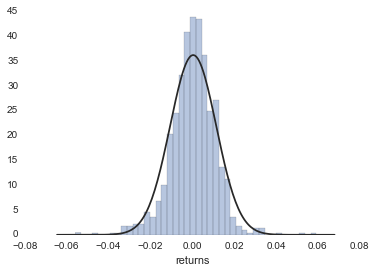

In [10]:
from scipy import stats
sns.distplot(data_0, kde=False, fit=stats.norm)
plt.xlabel('returns')

# How to estimate μ and σ?
* Naive: point estimate
* Set mu = mean(data) and sigma = std(data)
* Maximum Likelihood Estimate
* Correct answer as n→∞
# Bayesian analysis
* Most of the time n $\neq \infty$...
* Uncertainty about μ and σ
* Turn μ and σ into random variables
* How to estimate?

# A Toy Problem
* A 'toy' problem is a notion from Physics, that you use a simple problem first to derive insight.
* We will use one of Allen Downeys examples - the code is in PyMC2 and comes from Cameron Davidson-Pilon
* It is hard to find examples online that aren't influenced by either of these two heavyweights :) 

# First build the model then Infer. 
* Our first step is to build the model. 
* The second step is to infer. 

In the final match of the 2014 FIFA World Cup, Germany defeated Argentina 1-0. How much evidence does this victory provide that Germany had the better team? What is the probability that Germany would win a rematch?
- From Allen Downey

Our first step is that we need to make some Modelling decisions
* What kind of Model suits Football (Soocer)?
* Well we know empirically that scoring follows a Poisson process

"Scoring in games like soccer and hockey can be well modeled by a Poisson process, which assumes that each team, 
against a given opponent, will score goals at some goal-scoring rate, $\lambda$, and that this rate is stationary; 
in other words, the probability of scoring a goal is about the same at any point during the game." - Allen Downey

* A good framework for this is to use Bayesian Statistics
* We will use this in this example - and the code comes from Cameron Davidson-Pilon


In [12]:
import pymc as pm
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *

In [13]:
avg_goals_per_team = 1.34
duration_of_game = 93.


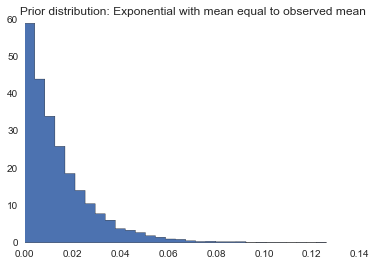

In [14]:
german_prior = pm.Exponential('german_prior', duration_of_game/avg_goals_per_team)
arg_prior = pm.Exponential('arg_prior', duration_of_game/avg_goals_per_team)

sample = np.array([german_prior.random() for i in range(10000)])
hist(sample, bins=30, normed=True, histtype='stepfilled');
plt.title('Prior distribution: Exponential with mean equal to observed mean');

* So now that we've done our Prior Distribution. We need to add some observed data and infer our Posterior.
* Our posterior is 'the probability of winning the final' or the 'what is the most likely result'
* We model the scoring function as a Poisson taking into account the Prior of the team and the observed data
* Finally we create a predictive model - which consists of the duration of the game*the prior 

In [15]:
germany = pm.Poisson('germany_obs', german_prior, observed=True, value=[1])
argentina = pm.Poisson('arg_obs', arg_prior, observed=True, value=[0])

germany_predictive = pm.Poisson('germany_predictive', duration_of_game*german_prior)
arg_predictive = pm.Poisson('arg_predictive', duration_of_game*arg_prior)

In [16]:
mcmc = pm.MCMC([germany, argentina, german_prior, arg_prior, germany_predictive, arg_predictive])


* Now we need to run the model :) 

In [17]:
mcmc.sample(20000, 5000)

 [-----------------100%-----------------] 20000 of 20000 complete in 2.5 sec

In [18]:
german_lambda_trace = mcmc.trace('german_prior')[:]
arg_lambda_trace = mcmc.trace('arg_prior')[:]

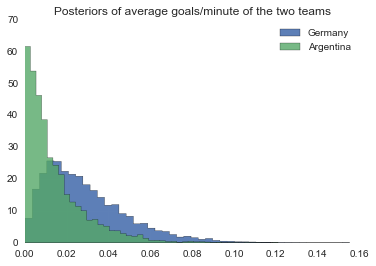

In [19]:
hist(german_lambda_trace, bins=45, histtype='stepfilled', label='Germany', 
     alpha=0.9, normed=True);
hist(arg_lambda_trace, bins=45, histtype='stepfilled', label='Argentina', 
     alpha=0.8, normed=True);
plt.legend();
plt.title('Posteriors of average goals/minute of the two teams');

In [20]:
german_post_trace = mcmc.trace('germany_predictive')[:]
arg_post_trace = mcmc.trace('arg_predictive')[:]

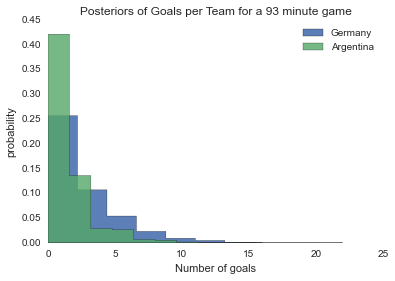

In [21]:

hist(german_post_trace, bins=10, histtype='stepfilled', label='Germany', alpha=0.9, normed=True);
hist(arg_post_trace, bins=10, histtype='stepfilled', label='Argentina', alpha=0.8, normed=True);
plt.legend();
plt.title('Posteriors of Goals per Team for a 93 minute game');
plt.ylabel('probability')
plt.xlabel('Number of goals')

In [22]:
print("Probability of Germany winning: %.3f"%(german_post_trace > arg_post_trace).mean())
print("Probability of Argentina winning: %.3f"%(german_post_trace < arg_post_trace).mean())
print("Probability of tie: %.3f"%(german_post_trace == arg_post_trace).mean())

Probability of Germany winning: 0.600
Probability of Argentina winning: 0.231
Probability of tie: 0.169


# Wrap up 
* We built a model of the 'teams strength' from our priors and our knowledge of scoring functions in Soccer.
* We can definitely apply this kind of formulation to OTHER problems
* Such as Rugby!
* Well done you just built a Probabilistic Programming Model :) 

###So what problem could I apply Bayesian models to?
* Rugby Analysis!
<img src="rugbyball.jpg", width="50%" height="50%"/>
Attribution: http://www.sportsballshop.co.uk

#Bayesian Rugby
 I came across the following blog post on http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/ 



* Based on the work of [Baio and Blangiardo](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf)


* In this talk, I'm going to reproduce the first model described in the paper using pymc.
* Since I am a rugby fan I decide to apply the results of the paper Bayesian Football to the Six Nations.


#So why Bayesians?
* Probabilistic Programming is a new paradigm.
* Attributions: My friend Thomas Wiecki influenced a lot of my thinking on this.
* I'm going to compare Blackbox Machine Learning with scikit-learn

<img src='https://raw.githubusercontent.com/twiecki/pymc3_talk/master/blackbox.png'>

* Source: <a href='https://speakerdeck.com/ogrisel/trends-in-machine-learning'>Olivier Grisel's talk on ML</a>


# Limitations of Machine learning
* A big limitation of Machine Learning is that most of the models are black boxes.



<img src='https://raw.githubusercontent.com/twiecki/pymc3_talk/master/openbox.png'>

Source: <a href='https://speakerdeck.com/ogrisel/trends-in-machine-learning'>Olivier Grisel's talk on ML</a>

# Probabilistic Programming - what's the big deal?
* We are able to use data and our prior beliefs to generate a model. 
* Generating a model is extremely powerful
* We can tell a story, which appeals to our understanding of stories. 


In [23]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc # I know folks are switching to "as pm" but I'm just not there yet
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
import seaborn as sns
figsize(12, 12)

# Six Nations Rugby
* Rugby is a physical sport popular worldwide.
* Six Nations consists of Italy, Ireland, Scotland, England, France and Wales
* Game consists of scoring tries (similar to touch downs) or kicking the goal.
* Average player is something like 100kg and 1.82m tall.
* Paul O'Connell the Irish captain is Height: 6' 6" (1.98 m) Weight: 243 lbs (110 kg)


#They compete for this!
* Significant this year because the World Cup occurs in 2015.
<img src="http://www.hostelrome.com/wp-content/uploads/2015/01/Rugby_Sei-Nazioni-Uomini.jpg">
* Photo: Hostelrome

## Motivation


* Your estimate of the strength of a team depends on your estimates of the other strengths
* Ireland are a stronger team than Italy for example - but by how much?
* Source for Results 2014 are Wikipedia. 
* I handcrafted these results
* Small data

<img src='smalldata.jpg'>

In [24]:
DATA_DIR = os.path.join(os.getcwd(), 'data/')

In [25]:
#The results_2014 is a handcrafted results table from Wikipedia
data_file = DATA_DIR + 'results_2014.csv'
df = pd.read_csv(data_file, sep=',')
df.tail()




,home_team,away_team,home_score,away_score
10,Scotland,France,17,19
11,England,Wales,29,18
12,Italy,England,11,52
13,Wales,Scotland,51,3
14,France,Ireland,20,22


In [26]:
teams = df.home_team.unique()
teams = pd.DataFrame(teams, columns=['team'])
teams['i'] = teams.index
teams.head()

,team,i
0,Wales,0
1,France,1
2,Ireland,2
3,Scotland,3
4,Italy,4


* Now we need to do some merging and munging

In [27]:
df = pd.merge(df, teams, left_on='home_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_home'}).drop('team', 1)
df = pd.merge(df, teams, left_on='away_team', right_on='team', how='left')
df = df.rename(columns = {'i': 'i_away'}).drop('team', 1)
df.head()

,home_team,away_team,home_score,away_score,i_home,i_away
0,Wales,Italy,23,15,0,4
1,France,England,26,24,1,5
2,Ireland,Scotland,28,6,2,3
3,Ireland,Wales,26,3,2,0
4,Scotland,England,0,20,3,5


In [28]:
observed_home_goals = df.home_score.values
observed_away_goals = df.away_score.values
home_team = df.i_home.values
away_team = df.i_away.values
num_teams = len(df.i_home.drop_duplicates())
num_games = len(home_team)


Now we need to prepare the model for PyMC.

In [29]:
g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())

# What do we want to infer?
* We want to infer the latent paremeters (every team's strength) that are generating the data we observe (the scorelines). 
* Moreover, we know that the scorelines are a noisy measurement of team strength, so ideally, we want a model that makes it easy to quantify our uncertainty about the underlying strengths.



# While my MCMC gently samples
* Often we don't know what the Bayesian Model is explicitly, so we have to 'estimate' the Bayesian Model'
* If we can't solve something, approximate it.
* Markov-Chain Monte Carlo (MCMC) instead draws samples from the posterior.
* Fortunately, this algorithm can be applied to almost any model.


# What do we want?
* We want to quantify our uncertainty
* We want to also use this to generate a model
* We want the answers as distributions *not* point estimates

## What assumptions do we know for our 'generative story'?
* We know that the Six Nations in Rugby only has 6 teams.
* We have data from last year!
* We also know that in sports scoring is modelled as a Poisson distribution
<img src="http://upload.wikimedia.org/wikipedia/commons/1/16/Poisson_pmf.svg">
* Attribution: *Wikipedia*

#The model.
<p>The league is made up by a total of T= 6 teams, playing each other once 
in a season. We indicate the number of points scored by the home and the away team in the g-th game of the season (15 games) as $y_{g1}$ and $y_{g2}$ respectively. </p>
<p>The vector of observed counts $\mathbb{y} = (y_{g1}, y_{g2})$ is modelled as independent Poisson:
$y_{gi}| \theta_{gj} \tilde\;\;  Poisson(\theta_{gj})$
where the theta parameters represent the scoring intensity in the g-th game for the team playing at home (j=1) and away (j=2), respectively.</p>




<p>We model these parameters according to a formulation that has been used widely in the statistical literature, assuming a log-linear random effect model:
$$log \theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$log \theta_{g2} = att_{a(g)} + def_{h(g)}$$
the parameter home represents the advantage for the team hosting the game
and we assume that this effect is constant for all the teams and
throughout the season. 



* Key assumption home effect is an advantage in Sports
* We know these things empirically from our 'domain specific' knowledge
* Bayesian Models allow you to incorporate *beliefs* or *knowledge* into your model!


In addition, the scoring intensity is 
determined jointly by the attack
and defense ability of the two teams involved, represented by the parameters att and def, respectively.
In line with the Bayesian approach, we have to specify some suitable prior distributions for all the 
random parameters in our model. The variable $home$ 
is modelled as a fixed effect, assuming a standard 
flat prior distribution. We use the notation of describing the Normal distribution in terms of mean 
and the precision. 
$home \tilde\; Normal(0,0.0001)$</p>
<p>Conversely, for each t = 1, ..., T, the team-specific effects are modelled as exchangeable from a common distribution:
$att_t \tilde\; Normal(\mu_{att}, \tau_{att})$
and $def_t \tilde\; Normal(\mu_{def}, \tau_{def})$</p>
<p>Note that they're breaking out team strength into attacking and defending strength. 
A negative defense parameter will sap the mojo from the opposing team&#39;s attacking parameter.</p>



<p>I made two tweaks to the model. It didn't make sense to me to have a $\mu_{att}$ when we&#39;re enforcing the sum-to-zero constraint by subtracting the mean anyway. So I eliminated $\mu_{att}$ and $\mu_{def}$</p>
<p>Also because of the sum-to-zero constraint, 
it seemed to me that we needed an intercept term in the log-linear model, capturing the average goals scored per game by the away team.
This we model with the following hyperprior.
$$intercept \tilde\; Normal(0, 0.001)$$</p>

* The hyper-priors on the attack and defense parameters are also flat
* $\mu_att \tilde\; Normal(0,0.001)$
* $\mu_def \tilde\; Normal(0,0.001)$
* $\tau_att \tilde\; \Gamma(0.1,0.1)$
* $\tau_def \tilde\; \Gamma(0.1,0.1)$

###Digression: Why the flat priors were picked (our hyperpriors are flat)
* There are lots of different ways of picking priors - see the literature
* I learned from this that it didn't make any difference to the results picking a uniform prior versus a flat prior

Often it simply doesn't matter much what prior you use. 





###Definition: A prior distribution is non-informative if the prior is “flat” relative to the likelihood function.


* We are trying to have a reasonable model and let inference happen from the data set.
* ##Key takeaway - Often in Bayesian modelling it doesn't matter what your priors are. Let the data generate the story :) 

In [30]:
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)
#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 




In [31]:
# trick to code the sum to zero constraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   



# Let us run the model!
* We specify the priors as Gamma distributions



In [32]:
home_points = pymc.Poisson('home_points', 
                          mu=home_theta, 
                          value=observed_home_goals, 
                          observed=True)
away_points = pymc.Poisson('away_points', 
                          mu=away_theta, 
                          value=observed_away_goals, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_points, away_points])
map_ = pymc.MAP( mcmc )
map_.fit()

mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 71.0 sec

#Diagnostics
Let's see if/how the model converged. 
The home parameter looks good, and indicates that home field advantage amounts to goals per game at the intercept.
We can see that it converges just like the model for the Premier League in the other tutorial.
I wonder and this is left as a question if all field sports have models of this form that converge.

Plotting home


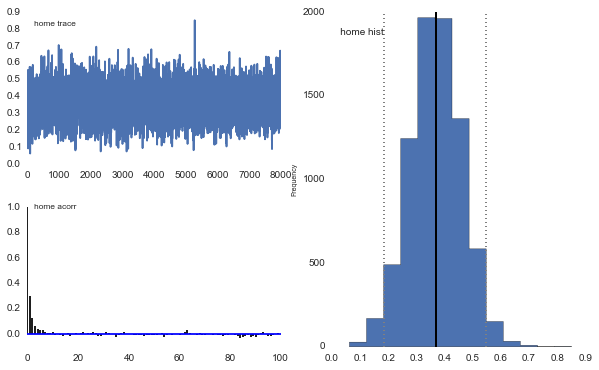

In [33]:
pymc.Matplot.plot(home)


* We can see in this analysis that home advantage gives about 0.55 points advantage.
* We also see not too much auto-correlation, so this looks quite good plot wise.
* We see here how *probabilistic programming* allows us to quantify our uncertainty about certain parameters.


Plotting atts_0
Plotting atts_1
Plotting atts_2
Plotting atts_3
Plotting atts_4
Plotting atts_5


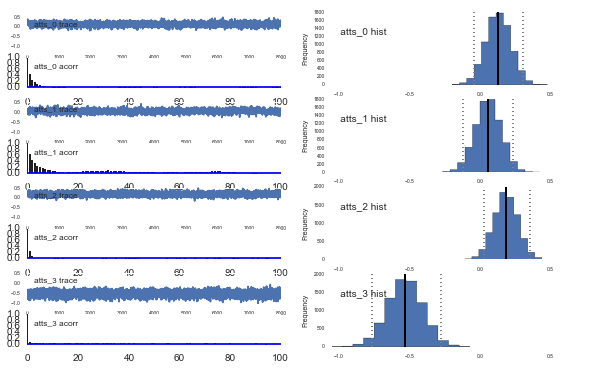

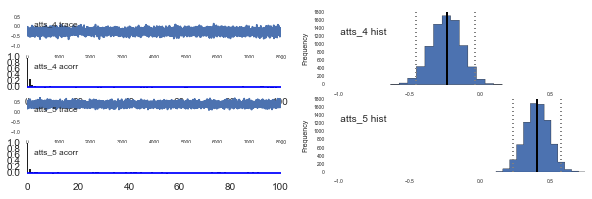

In [34]:
pymc.Matplot.plot(atts)
# We can plot all of the parameters, just to see. 

In [35]:
observed_season = DATA_DIR + 'table_2014.csv'
df_observed = pd.read_csv(observed_season)
df_observed.loc[df_observed.QR.isnull(), 'QR'] = ''
df_avg = pd.DataFrame({'avg_att': atts.stats()['mean'],
                       'avg_def': defs.stats()['mean']}, 
                      index=teams.team.values)


In [36]:
df_new = df_avg.merge(df_observed, left_index=True, right_on='team', how='left')

#Bring in the new csv file
df_results = pd.read_csv('df_avg_data_edited.csv', sep=';')

In [37]:
df_results.tail()

,avg_att,avg_def,points,team,position,QR
1,0.096729,0.150764,6,France,4,NaN
2,0.179363,-0.560665,8,Ireland,1,winners
3,-0.549843,0.289372,2,Scotland,5,NaN
4,-0.251418,0.515101,0,Italy,6,wooden_spoon
5,0.399824,-0.255811,8,England,2,triple_crown


In [38]:

def fig3():
    fig, ax = plt.subplots(figsize=(12,12))
    for outcome in ['winners', 'wooden_spoon', 'triple_crown', 'NaN']:
        ax.plot(df_results.avg_att[df_results.QR == outcome], 
    df_results.avg_def[df_results.QR == outcome], 'o', label=outcome)
    for label, x, y in zip(df_results.team.values, df_results.avg_att.values, df_results.avg_def.values):
        ax.annotate(label, xy=(x,y), xytext = (-5,5), textcoords = 'offset points')
        ax.set_title('Attack vs Defense avg effect: 13-14 Six Nations')
        ax.set_xlabel('Avg attack effect')
        ax.set_ylabel('Avg defense effect')
        ax.legend()

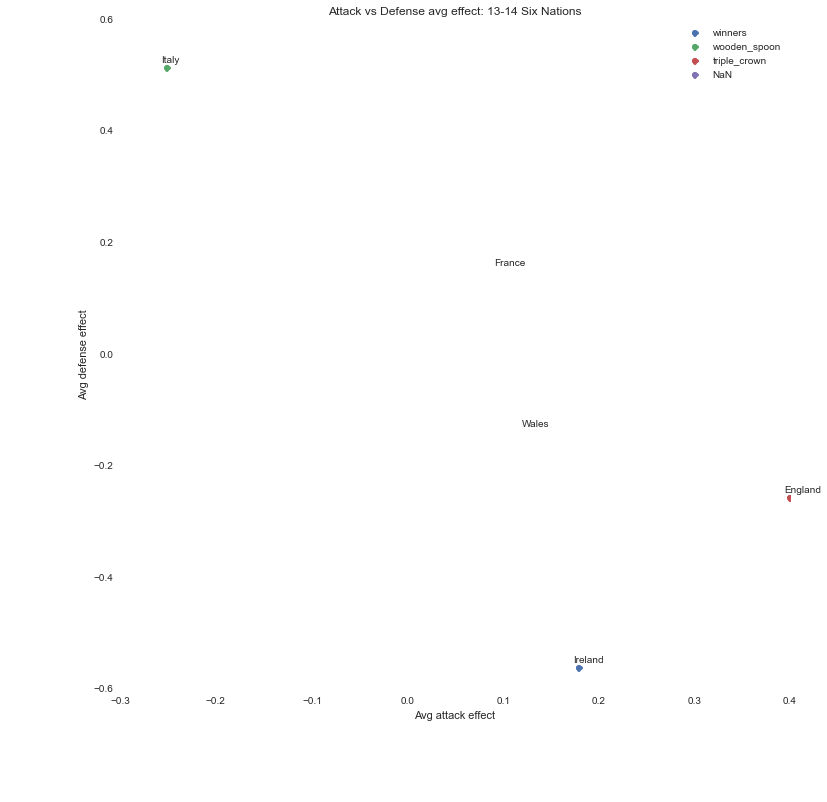

In [39]:
fig3()

#Simulating a season
We would like to now simulate a season. Just to see what happens. 

In [40]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_goals'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_goals'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] > x['away_goals'] else 
                                                    'loss' if x['home_goals'] < x['away_goals'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_goals'] < x['away_goals'] else 
                                                    'loss' if x['home_goals'] > x['away_goals'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_goals': g.home_goals.sum(),
                         'home_goals_against': g.away_goals.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_goals': g.away_goals.sum(),
                         'away_goals_against': g.home_goals.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins * 2
    df['gf'] = df.home_goals + df.away_goals
    df['ga'] = df.home_goals_against + df.away_goals_against
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['relegated'] = (df.position > 5).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

# Simulation
* We are going to simulate 1000 seasons


In [41]:
simuls = simulate_seasons(1000)

In [57]:
def fig1():
    figsize(9,9)
    ax = simuls.points[simuls.team == 'Ireland'].hist()
    median = simuls.points[simuls.team == 'Ireland'].median()
    ax.set_title('Ireland: 2015 points, 1000 simulations')
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

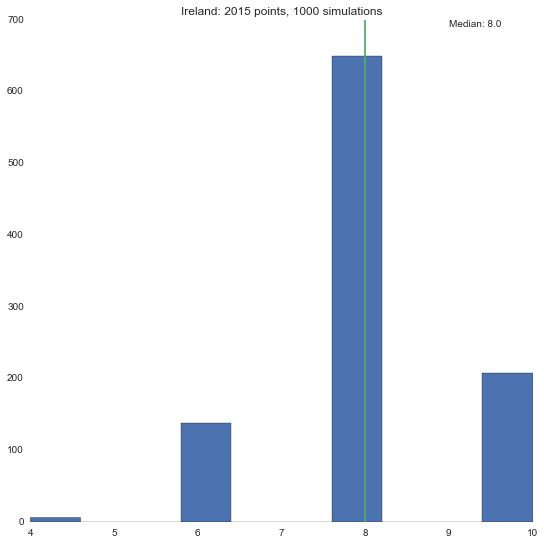

In [58]:
fig1()

* So what have we learned so far, we've got 1000 simulations of Ireland and their median points in the table is 8.
* In Rugby you get 2 points per win, and there are 5 games per year. So this model predicted that Ireland would win most of the time 4 games.


In [44]:
def fig2():
    ax = simuls.gf[simuls.team == 'Ireland'].hist(figsize=(7,5))
    median = simuls.gf[simuls.team == 'Ireland'].median()
    ax.set_title('Ireland: 2015 scores for, 1000 simulations')
    ax.plot([median, median], ax.get_ylim())
    plt.annotate('Median: %s' % median, xy=(median + 1, ax.get_ylim()[1]-10))

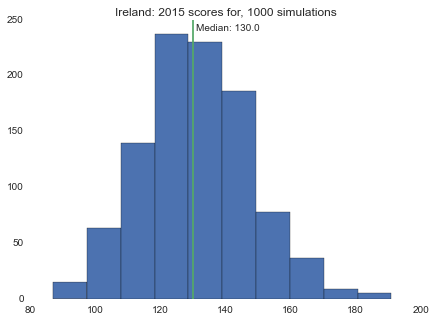

In [45]:
fig2()

#What happened in reality?
* Well Ireland actually scored 119 points, so the model over predicted this!
* We call this 'shrinkage' in the literature. 
* All models are wrong, but some are useful

# What are the predictions of the model?
* So let us look at the winning team on average.
* We do a simulation and we'll assign probability of 'winning' to the team
* We used the MCMC to do this.


In [46]:
g = simuls.groupby('team')
df_champs = pd.DataFrame({'percent_champs': g.champion.mean()})
df_champs = df_champs.sort_index(by='percent_champs')
df_champs = df_champs[df_champs.percent_champs > .05]
df_champs = df_champs.reset_index()

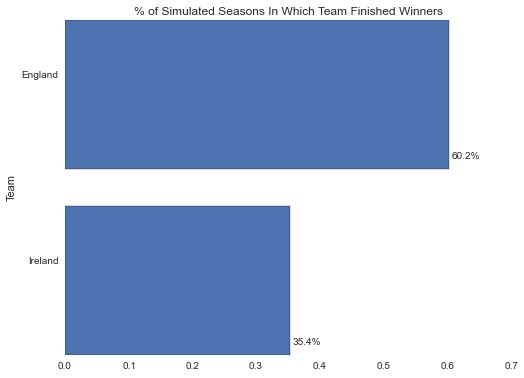

In [47]:

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(df_champs.index.values, df_champs.percent_champs.values)

for i, row in df_champs.iterrows():
    label = "{0:.1f}%".format(100 * row['percent_champs'])
    ax.annotate(label, xy=(row['percent_champs'], i), xytext = (3, 10), textcoords = 'offset points')
ax.set_ylabel('Team')
ax.set_title('% of Simulated Seasons In Which Team Finished Winners')
_= ax.set_yticks(df_champs.index + .5)
_= ax.set_yticklabels(df_champs['team'].values)

Unfortunately it seems that in most of the Universes England come top of the Six Nations. And as an Irish man this is firm proof that I put Mathematical rigour before patriotism :)
This is a reasonable result, and I hope it proved a nice example of Bayesian models in Rugby Analytics.

# What actually happened
We need to investigate like 'scientists' what actually happened.


In [48]:
pd.read_csv('data/results_2015.csv', sep='\t', header=0, 
            names =['Rank','Team','Games','Wins','Draws',
                    'Losses','Points_For','Points_Against','Points'])

,Rank,Team,Games,Wins,Draws,Losses,Points_For,Points_Against,Points
0,1,Ireland,5,4,0,1,119,56,8
1,2,England,5,4,0,1,157,100,8
2,3,Wales,5,4,0,1,146,93,8
3,4,France,5,2,0,3,103,101,4
4,5,Italy,5,1,0,4,62,182,2
5,6,Scotland,5,0,0,5,73,128,0


##Ireland won the Six Nations!
* The model incorrectly predicted that England would come out on top.
* Ireland actually won by points difference of 6 points. 
* It really came down to the wire!

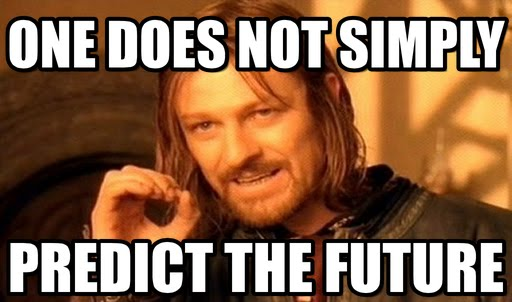

In [49]:
from IPython.display import Image
Image(filename='onedoesnotsimply.jpg') 

* One of the powers of Probabilistic Programming is that we can model 'latent' variables. 
* In Quantitative Finance we could model the 'fear' of investors. While we can't measure this directly.
* In our Rugby Prediction model we are trying to infer the 'strength' of the team. Whereas in reality we can only measure the 'score' of the team. 

Bayes' formula allows us to then infer backwards: given the observable data (e.g. the stock price), what is the probability of the latent construct (e.g. investor fear)? 

Attribution: Thomas Wiecki at Quantopian influenced me on this. 


What are the advantages of PyMC3?
What are the computational remarks?
Where is my table of contents?
Where is Bayes formula? 

#Stochastic volatility model
One elegant example of how Probabilistic Programming can infer 
unobservable quantities of the stock market is the stochastic volatility model. Volatility is an important concept of quantitative finance as it relates to risk. When I studied Financial Mathematics I was always confused about 'volatility' - since you can't measure it. 

If we can't measure something, the next best thing we can do is to try and model 
it. One way to do this is in a probabilistic framework is the concept of stochastic 
volatility: If we assume that returns are normally distributed, the volatility would be captured 
as the standard deviation of the normal distribution. Thus, the standard deviation gives rise to stochastic volatility. Intuitively we would assume that the standard deviation is high during times of market turmoil like the 2008 crash.



So the trivial thing to do would be to look at the rolling standard deviation of returns. But this is unsatisfying for multiple reasons:

* it often lags behind volatility,
* is a rather unstable measure,
* strongly dependent on the window size with no principled way of choosing it.

In fact a lot of 'business processes' we encounter as Data Scientists can't be measured directly. We can only 'model' how likely a person is to churn from our service for example. 
We can't infer exactly. 




# Introducing PyMC3
* PyMC3 is a complete rewrite
* Uses Theano and all of its computational coolness rather than Fortran.
* The API is cleaner, but I found it difficult to use since I know PyMC2 better
* The example I'll show first is a FinTech example for Stochastic Volatility 
* Attribution: The PyMC3 Development team.

# PyMC3 - continued
* Probabilistic Programming framework written in Python.
* Allows for construction of probabilistic models using intuitive syntax.
* Features advanced MCMC samplers.
* Fast: Just-in-time compiled by Theano.
* Extensible: easily incorporates custom MCMC algorithms and unusual probability distributions.
* Authors: John Salvatier, Chris Fonnesbeck, Thomas Wiecki
* Upcoming beta release!

In [50]:
import numpy as np
import pymc3 as pm3
from pymc3.distributions.timeseries import GaussianRandomWalk

from scipy.sparse import csc_matrix
from scipy import optimize

Asset prices have time-varying volatility (variance of day over day returns). In some periods, returns are highly variable, while in others very stable. Stochastic volatility models model this with a latent volatility variable, modeled as a stochastic process. The following model is similar to the one described in the No-U-Turn Sampler paper, Hoffman (2011) p21.
* $\sigma \;\; \tilde \;\;Exponential(50)$

* $\mu \;\;\tilde \;\; Exponential(.1)$

* $s_i\;\; \tilde \;\; Normal(s_{i−1},\sigma−2)$

* $\log(\frac{y_i}{yi−1})\;\;\tilde \;\;t(\nu ,0,\exp(−2s_{i}))$


Here, y is the daily return series and s is the latent log volatility process.



# Build the Model

In [60]:
def fig4():
    n = 400
    returns = np.genfromtxt("data/S&P500.csv")[-n:]
    returns[:5]




    np.array([-0.00637 , -0.004045, -0.02547 ,  0.005102, -0.047733])
    plt.plot(returns)


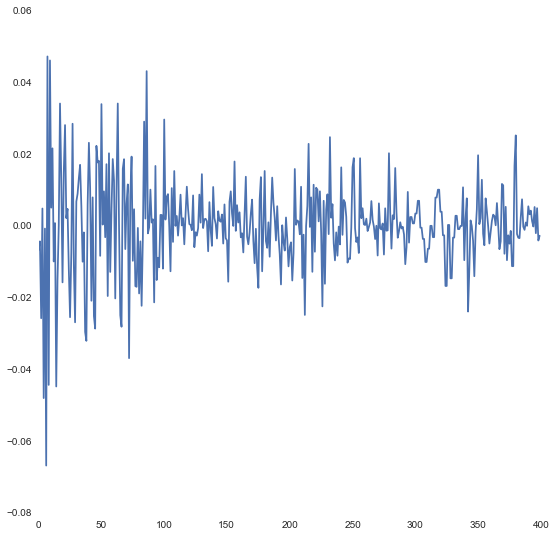

In [61]:
fig4()

* So so far we plotted our returns from the S and P 500.
Specifying the model in pymc3 mirrors its statistical specification.

However, it is easier to sample the scale of the log volatility process innovations, σ, on a log scale, so we create it using TransformedVar and use logtransform. 

TransformedVar creates one variable in the transformed space and one in the normal space. The one in the transformed space (here log(σ)) is the one over which sampling will occur, and the one in the normal space is the one to use throughout the rest of the model.

It takes a variable name, a distribution and a transformation to use.

One of the strengths of the PyMC3 API is that it allows you to write statistics quite naturally.

Personally it appeals to Data Developers like myself who are from a Mathematics Background. 



In [52]:
model = pm3.Model()
with model:
    sigma, log_sigma = model.TransformedVar('sigma', pm3.Exponential.dist(1./.02, testval=.1),
                                            pm3.logtransform)

    nu = pm3.Exponential('nu', 1./10)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm3.T('r', nu, lam=pm3.exp(-2*s), observed=returns)

# Fit the model
* Now that we have built the model and you can see the Syntax already.
* We need to fit the model. 


For this model, the full maximum a posteriori (MAP) point is degenerate and has infinite density. However, if we fix log_sigma and $\nu$ it is no longer degenerate, so we find the MAP with respect to the volatility process, 's', keeping log_sigma and $\nu$ constant at their default values.

We use L-BFGS because it is more efficient for high dimensional functions (s has n elements).

### Key Tip: The usage of clever scaling parameters to avoid degeneracy is an art of Bayesian Statistics

In [53]:
with model:
    start = pm3.find_MAP(vars=[s], fmin=optimize.fmin_l_bfgs_b)

We do a short initial run to get near the right area, then start again using a new Hessian at the new starting point to get faster sampling due to better scaling. 
We do a short run since this is an interactive example.

 [-----------------100%-----------------] 2001 of 2000 complete in 166.8 sec

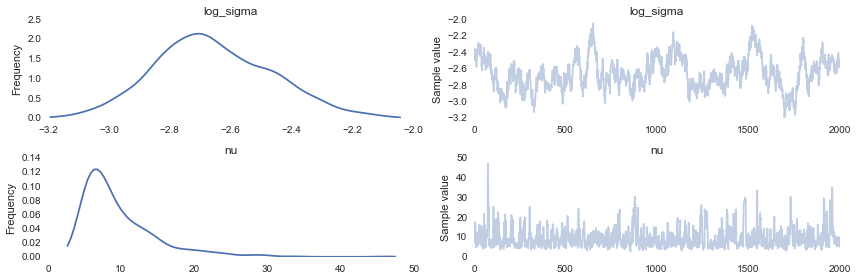

In [54]:
with model:
    step = pm3.NUTS(scaling=start)
    start2 = pm3.sample(500, step, progressbar=True)[-1]

    # Start next run at the last sampled position.
    step = pm3.NUTS(scaling=start2)
    trace = pm3.sample(2000, step, start=start2, progressbar=True)


figsize(12,6)
pm3.traceplot(trace, model.vars[:-1]);

* Looking at the returns over time and overlaying the estimated standard deviation we can see how the model tracks the volatility over time.

* This is exactly the sort of insight we expected.

* [PyMC3 Docs](http://pymc-devs.github.io/pymc3/stochastic_volatility/)

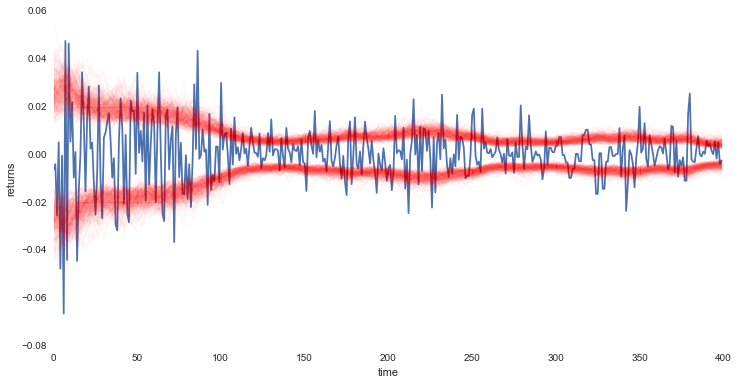

In [55]:
plot(returns)
plot(np.exp(trace[s][::10].T), 'r', alpha=.03);
sd = np.exp(trace[s].T)
plot(-np.exp(trace[s][::10].T), 'r', alpha=.03);
xlabel('time')
ylabel('returns')

In [73]:
import theano.tensor as T
import pymc3 as pm3
#hyperpriors


x = att_starting_points.values
y = def_starting_points.values
model = pm.Model()
with pm3.Model() as model:
    home3 = pm3.Normal('home', 0, .0001)
    tau_att3 = pm3.Gamma('tau_att', .1, .1)
    tau_def3 = pm3.Gamma('tau_def', .1, .1)
    intercept3 = pm3.Normal('intercept', 0, .0001)
    #team-specific parameters
    atts_star3 = pm3.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att3, 
                        observed=x)
    defs_star3 = pm3.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def3,  
                        observed=y) 
    
    #Seems to be the error here. 
    attsmean=atts_star3 - mean(atts_star3)
    atts = pm3.Deterministic(T('regression', attsmean))
    home_theta3 = pm3.Deterministic('regression', np.exp(intercept3 + atts[away_team] + defs[home_team]))
    
    atts = pm3.Deterministic('regression', atts_star3)
    home_theta3 = pm3.Deterministic('regression', np.exp(intercept3 + atts[away_team] + defs[home_team]))
    # Unknown model parameters
    home_points3 = pm3.Poisson('home_points', mu=home_theta3, observed=observed_home_goals)
    away_points3 = pm3.Poisson('away_points', mu=home_theta3, observed=observed_away_goals)
    start = pm3.find_MAP()
    step = pm3.NUTS(state=start)
    trace = pm3.sample(2000, step, start=start, progressbar=True)
    
    pm3.traceplot(trace)



/Users/peadarcoyle/anaconda/lib/python3.4/site-packages/pymc/Model.py:94: UserWarning: The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).
  'The MCMC() syntax is deprecated. Please pass in nodes explicitly via M = MCMC(input).')


AsTensorError: ('Cannot convert <pymc3.model.ObservedRV object at 0x12022a8d0> to TensorType', <class 'pymc3.model.ObservedRV'>)

# A financial example
* We are going to use a Financial Example from Quantopian. - Thomas Wiecki produced this
* [Value at Risk](https://en.wikipedia.org/wiki/Value_at_risk) is a standard financial measure in risk.
* The underlying message will be to look at the distributional assumptions in our models.
* Bayesian Statistics makes these very explicit

# Why does this matter?
* A lot of models have naive assumptions like 'the underlying phenomenoa is a Gaussian distribution'
* Those of us who deal with ecommerce data or commodity data or whatever know this just isn't true
* I want to show the power of this framework in Fin Tech :) 

# As we know: We want to approximate our Posterior with MCMC Sampling

In [ ]:
def plot_want_get():
    from scipy import stats
    fig = plt.figure(figsize=(14, 6))
    ax1 = fig.add_subplot(121, title='What we want', ylim=(0, .5), xlabel='', ylabel='')
    ax1.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-3, 3, 100)), lw=4.)
    ax2 = fig.add_subplot(122, title='What we get')#, xlim=(-4, 4), ylim=(0, 1800), xlabel='', ylabel='\# of samples')
    sns.distplot(np.random.randn(50000), ax=ax2, kde=False, norm_hist=True);
    ax2.set_xlim((-4, 4));
    ax2.set_ylim((0, .5));

In [ ]:
plot_want_get()

# MCMC allows us to approximate an integral
* This is the basic idea behind simulation methods like Monte Carlo
* There are other samplers which work better for integrals with discontinuities etc
* We could teach an entire 3 day workshop on all this cool stuff :) 


# We want to model our returns - specify our Priors :) 


In [ ]:
import theano.tensor as T
x = np.linspace(-.3, .3, 500)
plt.plot(x, T.exp(pm3.Normal.dist(mu=0, sd=.1).logp(x)).eval())
plt.title(u'Prior: mu ~ Normal(0, $.1^2$)'); plt.xlabel('mu'); plt.ylabel('Probability Density'); plt.xlim((-.3, .3));

In [ ]:
x = np.linspace(-.1, .5, 500)
plt.plot(x, T.exp(pm3.HalfNormal.dist(sd=.1).logp(x)).eval())
plt.title(u'Prior: sigma ~ HalfNormal($.1^2$)'); plt.xlabel('sigma'); plt.ylabel('Probability Density');

# Let us recap. 
* We have specified our priors, in terms of $\mu$ and $\sigma$. 
* We now need to specify our Bayesian Sharpe Ratio
* The Sharpe ratio is a common metric used to measure financial performance. 
* This could be any classical metric in your field. 

# Bayesian Sharpe Ratio
* $\mu \;\; \tilde \;\; Normal(0, .1^{2})$ <- Prior
* $\sigma \;\; \tilde \;\; HalfNormal(.1^{2})$ <- Prior
* Returns $\; \tilde \;\; Normal(\mu,  \sigma^{2})$ <- Observed
* Sharpe ratio $= \frac{\mu}{\sigma}$




<img src="http://blog.quantopian.com/wp-content/uploads/2014/12/GraphicalModel.jpg">
Attribution: Quantopian blog

# Not a bad idea to show the data :) 

In [ ]:
print(data_0.head())

In [ ]:

with pm3.Model() as model:
    # Priors on Random Variables
    mean_return = pm3.Normal('mean return', mu=0, sd=.1)
    volatility = pm3.HalfNormal('volatility', sd=.1)

    # Model returns as Normal
    obs = pm3.Normal('returns', 
                 mu=mean_return, 
                 sd=volatility,
                 observed=data_0)
    
    #There are 252 trading days in a year hence the 252 below
    sharpe = pm3.Deterministic('sharpe ratio', 
                           mean_return / volatility * np.sqrt(252))

In [ ]:
with model:
    # Instantiate MCMC sampler - in fact a No-U turn sampler
    step = pm3.NUTS()
    # Draw 1000 samples from the posterior
    trace = pm3.sample(1000, step)

# Now that we need to analyse our Posterior.
* Let us do some exploratory data analysis on our Posterior to see what it looks like

In [ ]:
sns.distplot(results_normal[0]['mean returns'], hist=False, label='etrade')
sns.distplot(results_normal[1]['mean returns'], hist=False, label='IB')
plt.title('Posterior of the mean'); plt.xlabel('mean returns')

In [ ]:
sns.distplot(results_normal[0]['volatility'], hist=False, label='etrade')
sns.distplot(results_normal[1]['volatility'], hist=False, label='IB')
plt.title('Posterior of the volatility')
plt.xlabel('volatility')

In [ ]:
sns.distplot(results_normal[0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_normal[1]['sharpe'], hist=False, label='IB')
plt.title('Bayesian Sharpe ratio'); plt.xlabel('Sharpe ratio');

In [ ]:
print('P(Sharpe ratio IB > 0) = %.2f%%' % \
    (np.mean(results_normal[1]['sharpe'] > 0) * 100))

In [ ]:
print('P(Sharpe ratio IB > Sharpe ratio etrade) = %.2f%%' % \
    (np.mean(results_normal[1]['sharpe'] > results_normal[0][0]['sharpe']) * 100))

# Value at Risk with uncertainty.
* We want to now compute our Value at Risk with Uncertainty 
* This shows the power of the Probabilistic Programming approach


In [ ]:
results_normal[0]

import scipy.stats as stats
ppc_etrade = post_pred(var_cov_var_normal, results_normal[0], 1e6, .05, samples=800)
ppc_ib = post_pred(var_cov_var_normal, results_normal[1], 1e6, .05, samples=800)
sns.distplot(ppc_etrade, label='etrade', norm_hist=True, hist=False, color='b')
sns.distplot(ppc_ib, label='IB', norm_hist=True, hist=False, color='g')
plt.title('VaR'); plt.legend(loc=0); plt.xlabel('5% daily Value at Risk (VaR) with \$1MM capital (in \$)'); 
plt.ylabel('Probability density'); plt.xticks(rotation=15);

# Interim summary
* Bayesian stats allows us to reformulate common risk metrics, use priors and quantify uncertainty.
* IB strategy seems better in almost every regard. Is it though?

# So far, let's add confidence

In [ ]:
sns.distplot(results_normal[0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_normal[1]['sharpe'], hist=False, label='IB')
plt.title('Bayesian Sharpe ratio'); plt.xlabel('Sharpe ratio');
plt.axvline(data_0.mean() / data_0.std() * np.sqrt(252), color='b');
plt.axvline(data_1.mean() / data_1.std() * np.sqrt(252), color='g');

In [ ]:
x = np.linspace(-.03, .03, 500)
ppc_dist_normal = post_pred(eval_normal, results_normal[1], x=x)
ppc_dist_t = post_pred(eval_t, results_t[1], x=x)

# How good is our model?
* Remember Box said "All models are wrong some are useful!"
* How useful is our model?

In [ ]:
sns.distplot(data_1, label='data IB', kde=False, norm_hist=True, color='.5')
for p in ppc_dist_normal:
    plt.plot(x, p, c='r', alpha=.1)
plt.plot(x, p, c='r', alpha=.5, label='Normal model')
plt.xlabel('Daily returns')
plt.legend();

#Can it be improved? Yes!
* Identical model as before, but instead, use a heavy-tailed T distribution:
* $returns\;\tilde \;\; T(\nu,\mu,\sigma^{2})$
 

In [ ]:
figsize(12, 12)
sns.distplot(data_1, label='data IB', kde=False, norm_hist=True, color='.5')
for p in ppc_dist_t:
    plt.plot(x, p, c='y', alpha=.1)
plt.plot(x, p, c='y', alpha=.5, label='T model')    
plt.xlabel('Daily returns')
plt.legend();

# Volatility

In [ ]:
sns.distplot(results_normal[1]['annual volatility'], hist=False, label='normal')
sns.distplot(results_t[1]['annual volatility'], hist=False, label='T')
plt.xlim((0, 0.2))
plt.xlabel('Posterior of annual volatility')
plt.ylabel('Probability Density');

# We need to compare posteriors

In [ ]:
sns.distplot(results_normal[1]['mean returns'], hist=False, color='r', label='normal model')
sns.distplot(results_t[1]['mean returns'], hist=False, color='y', label='T model')
plt.xlabel('Posterior of the mean returns'); plt.ylabel('Probability Density');

# Bayesian T-sharpe ratio

In [ ]:
sns.distplot(results_normal[1]['sharpe'], hist=False, color='r', label='normal model')
sns.distplot(results_t[1]['sharpe'], hist=False, color='y', label='T model')
plt.xlabel('Bayesian Sharpe ratio'); plt.ylabel('Probability Density');

# The robustness of the T-distribution is the strength of this model

In [ ]:
sim_data = list(np.random.randn(75)*.01)
sim_data.append(-.2)
sns.distplot(sim_data, label='data', kde=False, norm_hist=True, color='.5'); sns.distplot(sim_data, label='Normal', fit=stats.norm, kde=False, hist=False, fit_kws={'color': 'r', 'label': 'Normal'}); sns.distplot(sim_data, fit=stats.t, kde=False, hist=False, fit_kws={'color': 'y', 'label': 'T'})
plt.xlabel('Daily returns'); plt.legend();

# Estimating tail risk using VaR

In [ ]:
ppc_normal = post_pred(var_cov_var_normal, results_normal[1], 1e6, .05, samples=800)
ppc_t = post_pred(var_cov_var_t, results_t[1], 1e6, .05, samples=800)
sns.distplot(ppc_normal, label='Normal', norm_hist=True, hist=False, color='r')
sns.distplot(ppc_t, label='T', norm_hist=True, hist=False, color='y')
plt.legend(loc=0); plt.xlabel('5% daily Value at Risk (VaR) with \$1MM capital (in \$)'); 
plt.ylabel('Probability density'); plt.xticks(rotation=15);

# Comparing the Bayesian T-Sharpe Ratios

In [ ]:
sns.distplot(results_t[0]['sharpe'], hist=False, label='etrade')
sns.distplot(results_t[1]['sharpe'], hist=False, label='IB')
plt.xlabel('Bayesian Sharpe ratio'); plt.ylabel('Probability Density');

In [ ]:
print('P(Sharpe ratio IB > Sharpe ratio etrade) = %.2f%%' % \
    (np.mean(results_t[1]['sharpe'] > results_t[0]['sharpe']) * 100))

#Conclusion - Six Nations model
* 'All models are wrong, some are useful'
* Model correctly predicts that Ireland would win 4 games
* Model incorrectly predicted that England would come out on top
* In reality it was very close
* Recommendation: Don't use this model to bet on the Six Nations next years

# Conclusion: Probabilistic Programming
* **Probabilistic Programming** allows us to construct **complex models** in code and **automatically** estimate them.
* **Bayesian statistics** provides us with **uncertainty quantification** -- measure orthogonal sources of **risk**.
* **PyMC3** puts **advanced samplers** at your fingertips.
* **PyMC2** is less powerful than **PyMC3**


# Take home point
* Bayesian Models by forcing you to specify your priors. Allow you to make better decisions under situations of uncertainty.
* As Data Scientists we are always dealing with this.

##Want to learn more?
* [Thomas Wiecki Blog on all things Bayesian](https://twiecki.github.io)
* Twitter: [@springcoil](https://twitter.com/springcoil)
* [Probabilistic Programming for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/) -- IPython Notebook book on Bayesian stats using PyMC2

* [Doing Bayesian Data Analysis](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/) -- Great book by Kruschke.
* [Get PyMC3 alpha](https://github.com/pymc-devs/pymc/tree/pymc3)
* [Zalando Example](http://dataconomy.com/how-zalando-used-bayesian-statistics-to-save-loads-of-money/)

In [ ]:
from IPython.display import Image
Image(filename='the-most-interesting-man-in-the-world-meme-generator-i-don-t-give-many-talks-but-when-i-do-i-do-q-a-e38222 copy.jpg') 

In [ ]:
#Format from https://github.com/ellisonbg/talk-2013-scipy
from IPython.display import display, HTML
s = """

<style>

.rendered_html {
    font-family: "proxima-nova", helvetica;
    font-size: 100%;
    line-height: 1.3;
}

.rendered_html h1 {
    margin: 0.25em 0em 0.5em;
    color: #015C9C;
    text-align: center;
    line-height: 1.2; 
    page-break-before: always;
}

.rendered_html h2 {
    margin: 1.1em 0em 0.5em;
    color: #26465D;
    line-height: 1.2;
}

.rendered_html h3 {
    margin: 1.1em 0em 0.5em;
    color: #002845;
    line-height: 1.2;
}

.rendered_html li {
    line-height: 1.5; 
}

.prompt {
    font-size: 120%; 
}

.CodeMirror-lines {
    font-size: 120%; 
}

.output_area {
    font-size: 120%; 
}

#notebook {
    background-image: url('files/images/witewall_3.png');
}

h1.bigtitle {
    margin: 4cm 1cm 4cm 1cm;
    font-size: 300%;
}

h3.point {
    font-size: 200%;
    text-align: center;
    margin: 2em 0em 2em 0em;
    #26465D
}

.logo {
    margin: 20px 0 20px 0;
}

a.anchor-link {
    display: none;
}

h1.title { 
    font-size: 250%;
}

</style>
"""
display(HTML(s))